In [13]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [16]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [17]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [18]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0001])
    opt.set_upper_bounds([0.1])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return(res[0])

In [19]:
def calc_single_dist(x,rbp,g,L):
    d,h0,h1,h2,th = x
    
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [20]:
def single_chr_obj_fun(x_,arr):
    rbp, g, L = x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp,g,L),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [21]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [22]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [23]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [24]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['name'].unique())
    test = test.groupby(['distances'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,1,2,3,7]].to_numpy())
    #return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [25]:
df = pd.read_csv('mathematicaInputMice_unbinned.tsv',delimiter='\t')

In [26]:
df

,name,chrom,distances,no_het_bins,one_het_bins,two_het_bins,H0Prop,H1Prop,H2Prop,H
0,H12,chr1,1,62864864,844714.0,13604,0.986531,0.013256,0.000213,0.006841
1,H12,chr1,2,62850711,854466.0,8706,0.986452,0.013411,0.000137,0.006842
2,H12,chr1,3,62840557,856190.0,7807,0.986437,0.013440,0.000123,0.006843
3,H12,chr1,4,62831402,855898.0,7907,0.986438,0.013437,0.000124,0.006843
4,H12,chr1,5,62821707,856675.0,7467,0.986431,0.013452,0.000117,0.006843
...,...,...,...,...,...,...,...,...,...,...
199995,H36,chrX,996,33330821,249597.0,673,0.992547,0.007433,0.000020,0.003736
199996,H36,chrX,997,33326448,249349.0,779,0.992551,0.007426,0.000023,0.003736
199997,H36,chrX,998,33321896,249468.0,706,0.992548,0.007431,0.000021,0.003736
199998,H36,chrX,999,33317379,249504.0,668,0.992547,0.007433,0.000020,0.003736


Here obtaining a single estimate compositing over all distances with data pooled across individuals and replicates for chromosome 19 data only

because of discrete genome, we need to limit to a minimum distance for estimation, where double-mutation events are WAY less likely than recombination events, which confound results for short distance. 

The minimum distnce d is chosen so that (rho)(d) >> theta, i.e. d >> theta/rho. Here theta/rho ~= 5, so chosen d>= 50 as minimum distance.  This is in concordance with the single-distance estimates converging to the model expectation around that distance

In [37]:
def test_min_dist_effect_19(minDist):
    testPooled = df.loc[(df['chrom']=='chr19') & (df['distances']>= minDist)] 
    testPooled = combine_across_individuals(testPooled)
    
    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [49]:
jobs = list(range(1,500,5))
with Pool(cpu_count()) as p:
    estimateByMinDist=p.map(test_min_dist_effect_19,jobs)
estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))    

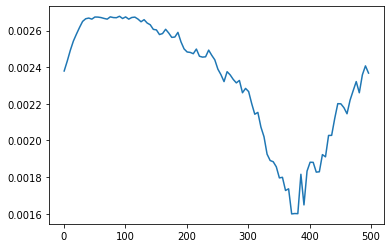

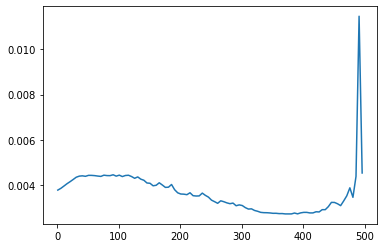

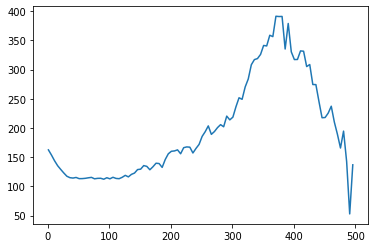

In [56]:
xvals = list(range(1,500,5))
plt.plot(xvals,estimateByMinDist[0])
plt.show()
plt.plot(xvals,estimateByMinDist[1])
plt.show()
plt.plot(estimateByMinDist[2])
plt.show()

# plotting the effect of minimum distance on estimates for all autosomes


In [27]:
autosomes = df.loc[(df['chrom']!='chrX')]

In [28]:
autosomes['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19'], dtype=object)

In [29]:
def calc_min_dist_effect_V2(argv):
    cName,minDist = argv
    testPooled = df.loc[(df['chrom']==cName) & (df['distances']>= minDist)] 
    testPooled = combine_across_individuals(testPooled)
    
    lowerBounds = [ 0.0001, 0.0001,10]
    upperBounds = [ 0.1, 0.1, 2000]
    startPoints = [ 0.001, 0.001, 50]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,3)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testPooled))
    res = opt.optimize(startPoints)
    return([x for x in res])

In [30]:
def get_chr_min_dist_effect_V2(cName):
    jobs = list(range(1,500,5))
    jobs = [(cName,x) for x in jobs]
    with Pool(cpu_count()) as p:
        estimateByMinDist=p.map(calc_min_dist_effect_V2,jobs)
    estimateByMinDist = np.transpose(np.asarray(estimateByMinDist))
    return(estimateByMinDist)

In [31]:
autosomeNames = autosomes['chrom'].unique()

In [32]:
resByChromosome = [ get_chr_min_dist_effect_V2(xs) for xs in autosomeNames]
print([np.ndarray.tolist(resByChromosome[i]) for i in list(range(len(resByChromosome)))])

[[[0.0009402602023560857, 0.0009817357978655766, 0.0010336409361998407, 0.001082925189729828, 0.0011284422404274114, 0.001172671087831415, 0.0012016467078369763, 0.0012348305996727218, 0.0012605533867142552, 0.0012790920874540903, 0.0012924544223806796, 0.0013102243335713817, 0.0013276797623851082, 0.0013340987135930706, 0.0013498811404252316, 0.0013578396838058323, 0.0013685107149081334, 0.0013697253555911353, 0.0013760365209080235, 0.0013843696562759794, 0.001386936854150945, 0.0013919732830696022, 0.0013954335828465227, 0.0013995238946365547, 0.001397958612453662, 0.0013887436181129957, 0.0013885082206936883, 0.0013775741712793834, 0.001368718575081293, 0.0013616611768176392, 0.001360651388201004, 0.0013613080361065946, 0.0013596639925670532, 0.001349089004611183, 0.0013404147956128625, 0.0013355517377915457, 0.0013294101686187776, 0.0013310550183970398, 0.0013190877128589893, 0.0013208317644828626, 0.001312264097769374, 0.0012971660135490254, 0.001292185330073381, 0.001268444462482

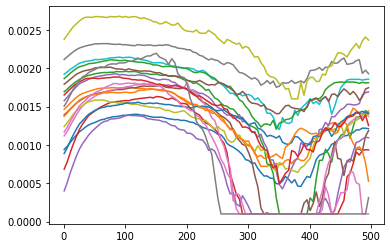

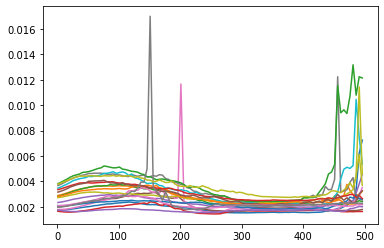

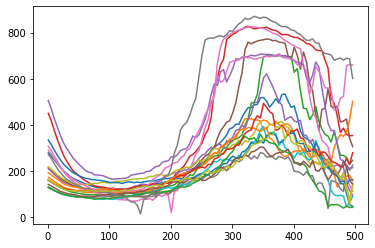

In [39]:
xvals = list(range(1,500,5))
for cRes in resByChromosome:
    plt.plot(xvals,cRes[0])
plt.show()
for cRes in resByChromosome:
    plt.plot(xvals,cRes[1])
plt.show()
for cRes in resByChromosome:
    plt.plot(xvals,cRes[2])
plt.show()